In [1]:
import re
import pandas as pd
from statistics import mean
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
stopwords = stopwords.words('english')
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv("../../data_Kaggle/train.csv")

In [3]:
train.head()

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [5]:
train["Comment"]

0                                    "You fuck your dad."
1       "i really don't understand your point.\xa0 It ...
2       "A\\xc2\\xa0majority of Canadians can and has ...
3       "listen if you dont wanna get married to a man...
4       "C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd...
                              ...                        
3942    "you are both morons and that is never happening"
3943    "Many toolbars include spell check, like Yahoo...
3944    "@LambeauOrWrigley\xa0\xa0@K.Moss\xa0\nSioux F...
3945    "How about Felix? He is sure turning into one ...
3946    "You're all upset, defending this hipster band...
Name: Comment, Length: 3947, dtype: object

## Nettoyage des messages

In [4]:
def clean_df(df_base, column):
    '''Cleaning column 'text' of a dataframe. Remove '@', links, punctuation and stopwords. Also tokenize the string

    Params:
        df - dataframe to be cleaned
    Returns:
        Cleaned dataframe
    '''
    
    df = df_base.copy(deep=True)
    #Remove @names
    df['clean'] = df[column].str.replace(r'@[A-Za-z0-9_]+', '', regex=True)
    df['clean'] = df['clean'].str.replace(r'http\S+', '', regex=True)
    
    #Remove space
    df['clean'] = df['clean'].map(lambda x: re.sub('\n', ' ', x))
    
    #Remove numbers
    df['clean'] = df['clean'].map(lambda x: re.sub(r'\d', '', x))
    
    # Remove punctuation
    df['clean'] = df['clean'].map(lambda x: re.sub('[,\.!?]"', ' ', x))
    
    # Convert the titles to lowercase
    df['clean'] = df['clean'].map(lambda x: x.lower())
    
    df['clean'] = df['clean'].apply(word_tokenize)
    
    df['clean'] = df['clean'].apply(lambda x: [item for item in x if item.isalpha()])
    
    lemmatizer = WordNetLemmatizer()
    df['clean'] = df['clean'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])
    
    df['clean'] = df['clean'].apply(lambda x: ' '.join(x))
    
    df['text_clean'] = df['clean'].astype(str)
    
    return df.drop(["Date","clean"], axis=1)

In [5]:
df_clean = clean_df(train, "Comment")

In [6]:
df_clean.head(8)

,Insult,Comment,text_clean
0,1,"""You fuck your dad.""",you fuck your dad
1,0,"""i really don't understand your point.\xa0 It ...",i really do understand your it seems that you ...
2,0,"""A\\xc2\\xa0majority of Canadians can and has ...",of canadian can and ha been wrong before now a...
3,0,"""listen if you dont wanna get married to a man...",listen if you dont wan na get married to a man...
4,0,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd...",giang ta khi sau tranh con
5,0,"""@SDL OK, but I would hope they'd sign him to ...",ok but i would hope they sign him to a contrac...
6,0,"""Yeah and where are you now?""",yeah and where are you now
7,1,"""shut the fuck up. you and the rest of your fa...",shut the fuck up you and the rest of your fagg...


In [7]:
df_clean1 = df_clean.drop(["Comment"], axis=1)

In [8]:
df_train, df_val = train_test_split(df_clean1, test_size=0.30, random_state=42)

print(df_train.shape)
print(df_val.shape)

(2762, 2)
(1185, 2)


In [9]:
test = pd.read_csv("../../data_Kaggle/test_with_solutions.csv")

In [10]:
df_test_clean = clean_df(test, "Comment")
df_test = df_test_clean.drop(["Comment", 'Usage'], axis=1)

In [11]:
#df_train.to_csv("../../data_models/df_train.csv", index=False)
#df_val.to_csv("../../data_models/df_val.csv", index=False)
#df_test.to_csv("../../data_models/df_test.csv", index=False)

# Undersampling Train Dataset

In [18]:
shuffled_df = df_train.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
insult_df = shuffled_df.loc[shuffled_df['Insult'] == 1]

#Randomly select 492 observations from the non-fraud (majority class)
non_insult_df = shuffled_df.loc[shuffled_df['Insult'] == 0].sample(n=732,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([insult_df, non_insult_df])

<AxesSubplot:xlabel='Insult', ylabel='count'>

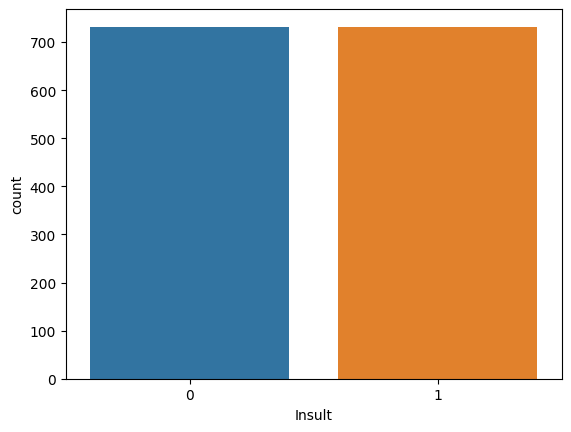

In [19]:
sns.countplot(data=normalized_df, x="Insult")
plt.title("Distribution des classes après undersampling (Train Dataset)")

In [21]:
#normalized_df.to_csv("../../data_models/df_train_undersampling.csv", index=False)